In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os
import pandas as pd

# Set dataset paths
DATASET_PATH = "/Users/maurice/Documents/data_nogit/Dermdetect/SAMPLE_20"  # Folder containing all images
CSV_FILE = "/Users/maurice/Documents/certification/dermdetect/csv/sample_dataset.csv"  # CSV file with image_id and target
IMG_SIZE = (299, 299)  # InceptionV3 input size
BATCH_SIZE = 32
EPOCHS = 1

# Data Augmentation and Image Loading
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3  # 20% of data for validation
)

train_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(CSV_FILE),
    directory=DATASET_PATH,
    x_col="image_id",
    y_col="target",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = False,
    class_mode='binary',
    subset="training"
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.read_csv(CSV_FILE),
    directory=DATASET_PATH,
    x_col="image_id",
    y_col="target",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle = False,
    class_mode='binary',
    subset="validation"
)

# Load InceptionV3 as Base Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze pretrained layers

# Custom Classification Head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define Model
model = Model(inputs=base_model.input, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', 'AUC'])

# Train Model
model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    verbose=1
)




Found 10164 validated image filenames belonging to 2 classes.
Found 4356 validated image filenames belonging to 2 classes.


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


318/318 ━━━━━━━━━━━━━━━━━━━━ 218s 678ms/step - AUC: 0.8139 - Precision: 0.7292 - Recall: 0.7200 - accuracy: 0.7368 - loss: 0.5158 - val_AUC: 0.9079 - val_Precision: 0.8185 - val_Recall: 0.8290 - val_accuracy: 0.8223 - val_loss: 0.3860


In [2]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Faire les prédictions sur le générateur de validation
pred_probs = model.predict(val_generator, steps=len(val_generator), verbose=1)

# Convertir les probabilités en classes binaires (seuil de 0.5)
pred_classes = (pred_probs > 0.5).astype(int)

# Récupérer les vraies étiquettes
true_labels = val_generator.classes


137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 488ms/step


In [3]:
# Calcul des métriques
accuracy = accuracy_score(true_labels, pred_classes)
precision = precision_score(true_labels, pred_classes)
recall = recall_score(true_labels, pred_classes)
f1 = f1_score(true_labels, pred_classes)
auc = roc_auc_score(true_labels, pred_probs)  # Attention, on utilise les probabilités ici

# Affichage des résultats
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUC: {auc:.4f}")


Accuracy: 0.8223
Precision: 0.8185
Recall: 0.8290
F1-score: 0.8237
AUC: 0.9079


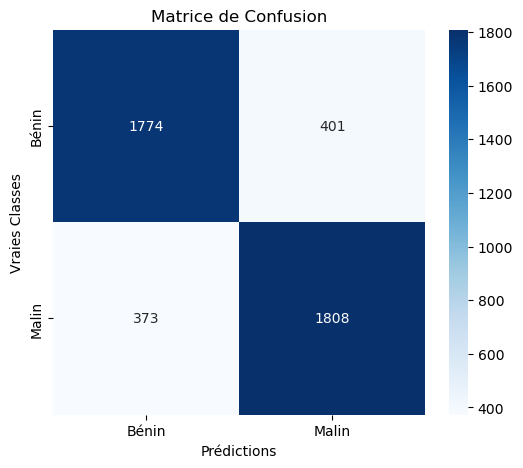

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import plotly.express as px

# Calculer la matrice de confusion
cm = confusion_matrix(true_labels, pred_classes)

# Affichage avec Matplotlib et Seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Bénin', 'Malin'], yticklabels=['Bénin', 'Malin'])
plt.xlabel("Prédictions")
plt.ylabel("Vraies Classes")
plt.title("Matrice de Confusion")
plt.savefig("confusion_matrix.png")  # Sauvegarder l'image
plt.show()

# Affichage interactif avec Plotly Express
df_cm = pd.DataFrame(cm, index=['Bénin', 'Malin'], columns=['Bénin', 'Malin'])
fig = px.imshow(df_cm, text_auto=True, color_continuous_scale='Blues')
fig.update_layout(title="Matrice de Confusion", xaxis_title="Prédictions", yaxis_title="Vraies Classes")
fig.show()


In [4]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve

y_true = np.array(val_generator.classes)  # Ensure correct order
y_pred_prob = model.predict(val_generator).ravel()  # Get probabilities


fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)  # Best balance between TPR & FPR
optimal_threshold = thresholds[optimal_idx]

y_pred = (y_pred_prob > optimal_threshold).astype("int32")

print(f"Optimal Threshold: {optimal_threshold:.4f}")

137/137 ━━━━━━━━━━━━━━━━━━━━ 67s 488ms/step
Optimal Threshold: 0.4452


In [5]:
accuracy = np.mean(y_pred == y_true)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

In [6]:
print(accuracy, precision, recall, f1)

0.8278236914600551 0.8017714044706875 0.8716185236130215 0.8352372583479789
